In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/magdalenastrauss/Documents/GPclust')
sys.path.append('/Users/magdalenastrauss/Documents/GPy')
sys.path.append('/anaconda/lib/python3.6/site-packages')
import numpy as np
import os
import GPy
import GPclust

warning in stationary: failed to import cython module: falling back to numpy


Define functions to load data

In [5]:
def load_data(expr_file, times_file):
    expression = np.loadtxt(expr_file, delimiter=',')
    times = np.loadtxt(times_file, delimiter=',')
    # remove genes with no variance
    std = expression.std(axis=1)
    nonzero_var = std != 0.
    expression = expression[nonzero_var]
    # normalize data row-wise
    expression -= expression.mean(axis=1)[:, np.newaxis]
    expression /= std[nonzero_var, np.newaxis]
    return expression, times

Define function to fit GPClust model

In [6]:
def fit_gpclust(underlying_variance, underlying_lengthscale,
                corruption_variance, corruption_lengthscale,
                noise_variance,
                expression,
                times,
                kernel=GPy.kern.Matern52,
                K=20,
                alpha=1.0):
    k_underlying = kernel(input_dim=1,
                          variance=underlying_variance,
                          lengthscale=underlying_lengthscale)
    k_corruption = \
        kernel(input_dim=1,
               variance=corruption_variance,
               lengthscale=corruption_lengthscale) + \
        GPy.kern.White(1, variance=noise_variance)
    m = GPclust.MOHGP(times.reshape(-1,1), k_underlying, k_corruption,
                      expression, K=20, prior_Z='DP', alpha=1.0)
    m.hyperparam_opt_interval = 1000 # how often to optimize the hyperparameters
    m.hyperparam_opt_args['messages'] = False # don't print optimization messages
    m.optimize()
    m.systematic_splits(verbose=False)  
    m.reorder()  # move biggest clusters to the top
    print(m)
    return m

In [10]:
def save_cluster_allocations(phi,fileName): 
    clusterAllocVector = np.zeros((1,phi.shape[0])) 
    for j in range(1,phi.shape[1]+1):
        k = j-1
        clusterAllocVector[0,np.argmax(phi,1)==k] = j
        np.savetxt(fileName, clusterAllocVector, delimiter=',')
    return clusterAllocVector  

# Simulation - SLICER

In [8]:
sim_expr, sim_slicer_times = \
    load_data("simSLICER.csv", "pseudoTimesSimSLICER.csv")
sim_lengthscale = sim_slicer_times[-1]  # Take last pseudotime as lengthscale
m_sim_slicer = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_slicer_times)

iteration 1 bound=-4523.60878686 grad=534.246355738, beta=0
iteration 2 bound=-4395.2912801 grad=1581.95533252, beta=1.03707761455
iteration 3 bound=-4347.93771743 grad=92.8515132581, beta=0.0


 /Users/magdalenastrauss/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


iteration 4 bound=-4317.16994276 grad=74.8091935583, beta=1.3118291128
iteration 5 bound=-4310.05498697 grad=121.334157568, beta=0.484221084437
iteration 7 bound=-4330.08848091 grad=86.9770269135, beta=0.0
iteration 9 bound=-4275.06596419 grad=269.500976339, beta=8.93550810326
iteration 11 bound=-5012.05047236 grad=1.50457518443, beta=0.0
iteration 12 bound=-5008.08051371 grad=0.0224948313159, beta=0.0
iteration 13 bound=-4748.48251996 grad=0.0302396414899, beta=0.0
iteration 15 bound=-4658.40342682 grad=1418.95587313, beta=4200.04152354
iteration 16 bound=-4596.04694093 grad=444.617288088, beta=0.0
iteration 17 bound=-4594.57549234 grad=1.82447136106, beta=0.0115624374276
iteration 18 bound=-4557.13327666 grad=6.07764722402, beta=7.680515587
iteration 19 bound=-4473.79331543 grad=44.9206858055, beta=0.0
iteration 21 bound=-5008.08023467 grad=267.689602925, beta=2.90172856214
iteration 22 bound=-4749.76633974 grad=1.88662074232e-10, beta=0.0
vb converged (gtol)
iteration 23 bound=-3539

 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars



Name : MOHGP
Objective : 3008.3367949012277
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  MOHGP.                 |              value  |  constraints  |  priors
  Mat52.variance         |      0.65703588068  |      +ve      |        
  Mat52.lengthscale      |    0.0224376430797  |      +ve      |        
  sum.Mat52.variance     |  1.72479577372e-06  |      +ve      |        
  sum.Mat52.lengthscale  |       4.9038473688  |      +ve      |        
  sum.white.variance     |     0.291870523175  |      +ve      |        


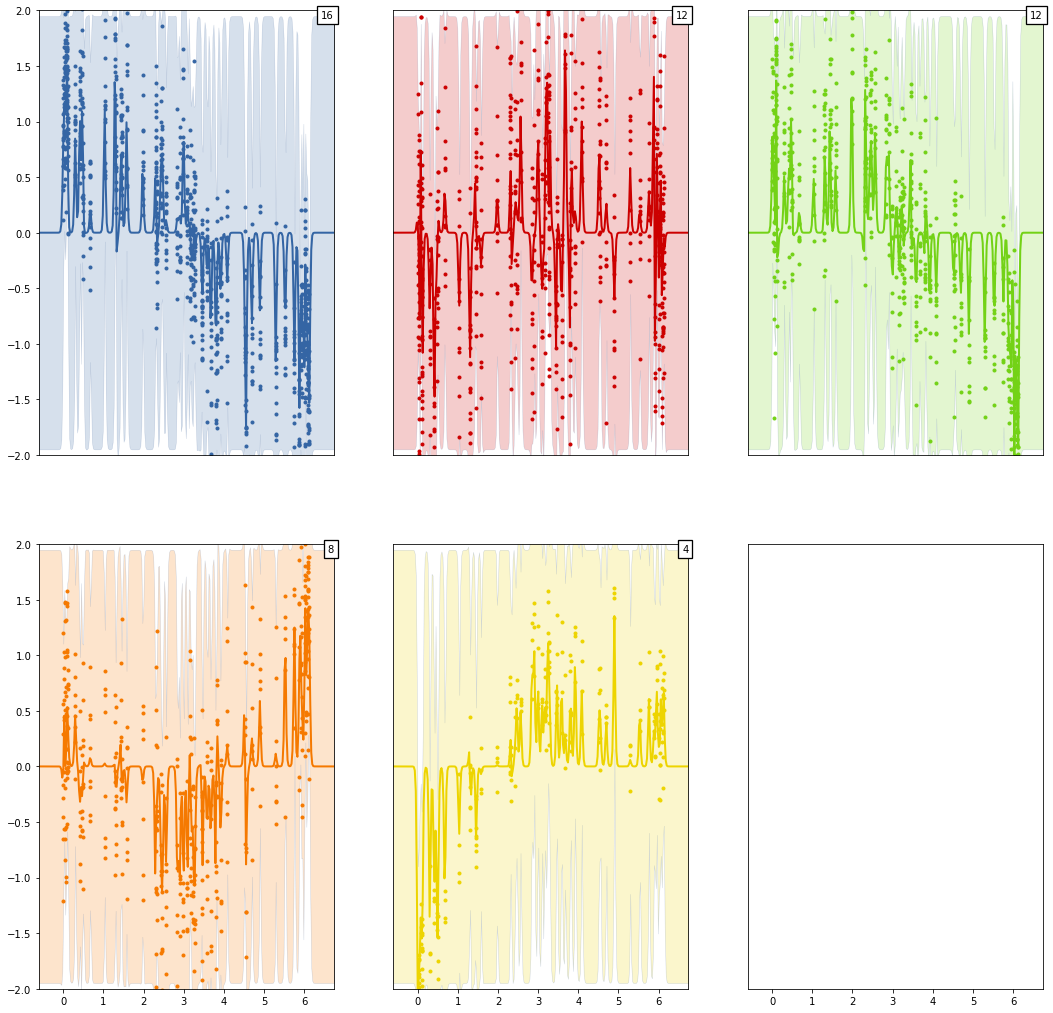

In [9]:
plt.figure(figsize=(18,18))
m_sim_slicer.plot(on_subplots=True, colour=True, in_a_row=False,
                  newfig=False, min_in_cluster=1, joined=False, ylim=(-2,2))


In [15]:
save_cluster_allocations(m_sim_slicer.phi,'GPClustSim1Slicer.csv')

array([[ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.]])

In [30]:
#second data set
sim_expr, sim_slicer_times = \
    load_data("simSLICER2.csv", "pseudoTimesSimSLICER2.csv")
sim_lengthscale = sim_slicer_times[-1]  # Take last pseudotime as lengthscale
m_sim_slicer2 = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_slicer_times)

iteration 1 bound=-7365.6384207 grad=88.9888688976, beta=0
iteration 2 bound=-7301.39998102 grad=263.641958839, beta=2.12257133087
iteration 3 bound=-7239.04815831 grad=97.3134463473, beta=0.0
iteration 4 bound=-7224.8508207 grad=33.6052515045, beta=0.0
iteration 6 bound=-7217.37861482 grad=12.3103534682, beta=268.807927979
iteration 7 bound=-7209.78793072 grad=7.59539567778, beta=1.36345926162
iteration 9 bound=-7252.75768061 grad=4.20256978281, beta=7.26884548044
iteration 11 bound=-7432.70156902 grad=34.5940341728, beta=23.6029902618
iteration 12 bound=-7431.75963223 grad=6.39177392436e-10, beta=0.0
vb converged (gtol)
iteration 13 bound=-4441.48747042 grad=1.01967034819, beta=125317698417.0
iteration 14 bound=-4403.1285502 grad=0.0, beta=-0.0
vb converged (gtol)
iteration 16 bound=-4367.55363068 grad=40.7300205768, beta=inf
iteration 17 bound=-4362.38542809 grad=7.30894940112, beta=0.0
iteration 18 bound=-4359.63590163 grad=3.44121344372, beta=0.019306546145


 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:164: RuntimeWarning:divide by zero encountered in double_scalars
 /Users/magdalenastrauss/Documents/GPclust/GPclust/collapsed_vb.py:167: RuntimeWarning:invalid value encountered in multiply


iteration 19 bound=-4357.60582974 grad=2.06880510452, beta=0.0
iteration 20 bound=-4357.03642023 grad=2.42740218103, beta=8.94695886491
iteration 21 bound=-4346.96727051 grad=24.4668229023, beta=0.0
iteration 22 bound=-4345.85266924 grad=1.55409779325, beta=0.0817532440145
iteration 23 bound=-4345.56702797 grad=0.416014580602, beta=0.0588601735416
iteration 24 bound=-4345.4800596 grad=0.0904392358251, beta=0.26252946498
iteration 25 bound=-4345.44765216 grad=0.0349192851505, beta=0.0452244316407
iteration 26 bound=-4345.41666533 grad=0.0225880364164, beta=0.611732093791
iteration 27 bound=-4345.40214776 grad=0.0101639228845, beta=0.441679084473
iteration 28 bound=-4345.39774626 grad=0.00308521000415, beta=0.422538748759
iteration 29 bound=-4345.39715104 grad=0.000495673121262, beta=0.257886007875
iteration 30 bound=-4345.39707018 grad=9.22581364753e-05, beta=0.200047300862
iteration 31 bound=-4345.39705092 grad=2.37855054658e-05, beta=0.250815001717
iteration 32 bound=-4345.39704402 gr

In [31]:
save_cluster_allocations(m_sim_slicer2.phi,'GPClustSim2Slicer.csv')

array([[ 7.,  6.,  5.,  5.,  7.,  5.,  5.,  6.,  4.,  4.,  4.,  4.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.]])

# Simulation - DeLorean

In [23]:
#Comment: this sometimes needs to be rerun a few times to avoid local or boundary optima
#such as all genes in one cluster, or very large length scale and very large noise
sim_expr, sim_DL_times = \
    load_data("deLoreanSim.csv", "deLoreanTSim.csv")
sim_lengthscale = sim_DL_times[-1]  # Take final pseudotime as lengthscale
m_sim_DL = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_DL_times)

iteration 1 bound=-4511.60363677 grad=599.487125126, beta=0
iteration 2 bound=-4306.99985142 grad=2004.10286312, beta=1.44945240211
iteration 4 bound=-5127.29809416 grad=35.2490539754, beta=0.0
iteration 5 bound=-4678.47197947 grad=25.0450735515, beta=0.0
iteration 6 bound=-4605.25073552 grad=445.557413891, beta=69.1625942563
iteration 7 bound=-4333.97473122 grad=0.00185606824805, beta=0.0
iteration 9 bound=-5183.94257734 grad=0.770388811531, beta=2055.56985256
iteration 10 bound=-5151.8373909 grad=20.7210697408, beta=0.0
iteration 11 bound=-5036.09347779 grad=3.0113556984e-10, beta=3.73762399056e-11
vb converged (gtol)
iteration 12 bound=-3524.05288682 grad=2.65259650754, beta=29308214330.1
iteration 13 bound=-3515.81466861 grad=0.199594301305, beta=0.0
iteration 15 bound=-3516.28973909 grad=3.62558333386, beta=127642706495.0
iteration 17 bound=-3510.17668888 grad=27.2488332155, beta=198.893616918
iteration 18 bound=-3509.4321137 grad=1.14859664331, beta=0.0137694016414
iteration 20 b

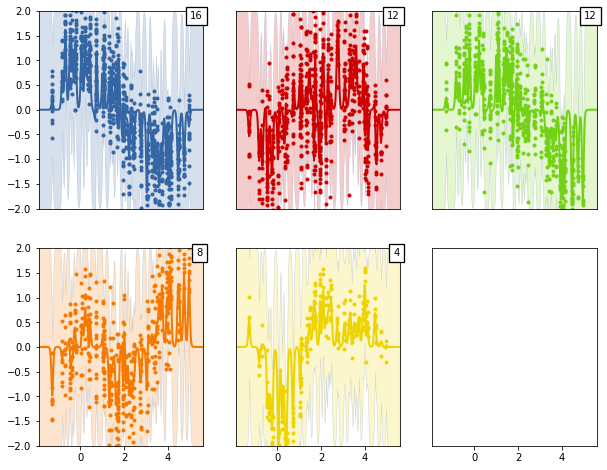

In [24]:

plt.figure(figsize=(10,8))
m_sim_DL.plot(on_subplots=True, colour=True, in_a_row=False,
              newfig=False, min_in_cluster=1, joined=False, ylim=(-2,2))
plt.savefig('Sim-DL.svg')

In [25]:
save_cluster_allocations(m_sim_DL.phi,'GPClustSim1DL.csv')

array([[ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.]])

In [33]:
sim_expr, sim_DL_times = \
    load_data("deLoreanSim2.csv", "deLoreanTSim2.csv")
sim_lengthscale = sim_DL_times[-1]  # Take final pseudotime as lengthscale
m_sim_DL2 = \
    fit_gpclust(underlying_variance=1.,
                underlying_lengthscale=sim_lengthscale,
                corruption_variance=.2,
                corruption_lengthscale=sim_lengthscale,
                noise_variance=.2,
                expression=sim_expr,
                times=sim_DL_times)
save_cluster_allocations(m_sim_DL2.phi,'GPClustSim2DL.csv')

iteration 1 bound=-6491.18305282 grad=442.778628441, beta=0
iteration 2 bound=-6414.43156949 grad=464.401754671, beta=0.363768207582
iteration 3 bound=-6402.86469549 grad=26.5481209199, beta=0.0
iteration 4 bound=-6395.34582938 grad=11.4133402585, beta=0.0
iteration 5 bound=-6393.94038709 grad=3.36527769221, beta=0.603280999945
iteration 6 bound=-6393.52183811 grad=0.81776143634, beta=0.0
iteration 7 bound=-6393.34360924 grad=0.18217945422, beta=1.123862729
iteration 8 bound=-6393.01231413 grad=0.41247568034, beta=0.0
iteration 10 bound=-6392.7026195 grad=0.407426964071, beta=2.72156746209
iteration 12 bound=-6392.25097453 grad=0.458694064525, beta=2.70813301168
iteration 13 bound=-6391.80881378 grad=0.855705197745, beta=1.25107582628
iteration 14 bound=-6391.80379265 grad=0.0182600030198, beta=0.0
iteration 16 bound=-6392.72943154 grad=0.00232809124125, beta=0.0
iteration 17 bound=-6391.80768929 grad=4.88603562324, beta=0.0
iteration 18 bound=-6391.8031058 grad=0.0179149330469, beta=0

array([[ 4.,  4.,  7.,  4.,  4.,  4.,  4.,  6.,  5.,  5.,  5.,  5.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.]])